<a href="https://colab.research.google.com/github/aruaru0/SAM-TEST/blob/main/Fast_SAM_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インストール

In [1]:
!pip uninstall --yes tensorflow-probability

Found existing installation: tensorflow-probability 0.22.0
Uninstalling tensorflow-probability-0.22.0:
  Successfully uninstalled tensorflow-probability-0.22.0


In [2]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
%cd FastSAM
!pip install -r requirements.txt

Cloning into 'FastSAM'...
remote: Enumerating objects: 1221, done.
remote: Counting objects: 100% (289/289), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 1221 (delta 229), reused 205 (delta 196), pack-reused 932
Receiving objects: 100% (1221/1221), 72.46 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (486/486), done.
/content/FastSAM
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3auzlvql
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3auzlvql
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=8bfce9b7c65087e891439eaf3a8193c2f41ad1dd44c72582992c148c7001410c
  Stored in directory: /tmp/pip-ephem-wheel-cache-s3bk422v/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


In [4]:
from fastsam import FastSAM, FastSAMPrompt

In [5]:
# https://qiita.com/namakemono/items/c963e75e0af3f7eed732
!curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv" > /dev/null
!CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"  ; curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${CODE}&id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv" -o FastSAM-x.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  138M  100  138M    0     0  55.2M      0  0:00:02  0:00:02 --:--:--  155M


# ヘルパー関数

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def draw_box(img, boxes) :
  for x1, y1, x2, y2 in boxes :
     img = cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
  return img


def draw_point(img, points, labels) :
  for (x, y), label in zip(points, labels) :
    if label == 1 :
      img = cv2.circle(img, (x, y), radius = 10, color = (0,255,0), thickness=-1)
      img = cv2.circle(img, (x, y), radius = 10, color = (0,0,0), thickness=2)
    else :
      img = cv2.circle(img, (x, y), radius = 10, color = (0,0,255), thickness=-1)
      img = cv2.circle(img, (x, y), radius = 10, color = (0,0,0), thickness=2)

  return img

# 画像の読み込み

In [7]:
!wget -O cat2.png https://github.com/aruaru0/SAM-TEST/blob/main/cat2.png?raw=true

--2023-12-01 06:41:13--  https://github.com/aruaru0/SAM-TEST/blob/main/cat2.png?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/aruaru0/SAM-TEST/raw/main/cat2.png [following]
--2023-12-01 06:41:14--  https://github.com/aruaru0/SAM-TEST/raw/main/cat2.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aruaru0/SAM-TEST/main/cat2.png [following]
--2023-12-01 06:41:14--  https://raw.githubusercontent.com/aruaru0/SAM-TEST/main/cat2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638240 (623K) [image/png]
Sa

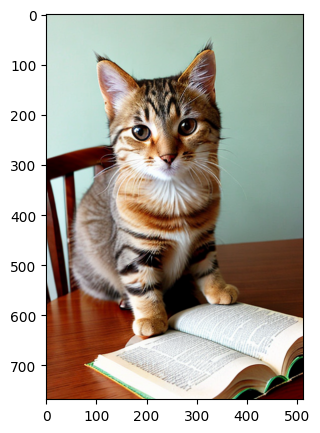

In [8]:
image = cv2.imread('cat2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

# 点を指定してセグメンテーション（複数マスク出力）

In [9]:
import cv2
from google.colab.patches import cv2_imshow

In [10]:
from fastsam import FastSAM, FastSAMPrompt

model = FastSAM('./FastSAM-x.pt')
device = "cpu"
everything_results = model(image, device=device, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9,)
prompt_process = FastSAMPrompt(image, everything_results, device=device)


0: 1024x704 20 objects, 16727.7ms
Speed: 25.0ms preprocess, 16727.7ms inference, 141.7ms postprocess per image at shape (1, 3, 1024, 1024)


# Everything

torch.Size([20, 768, 512])


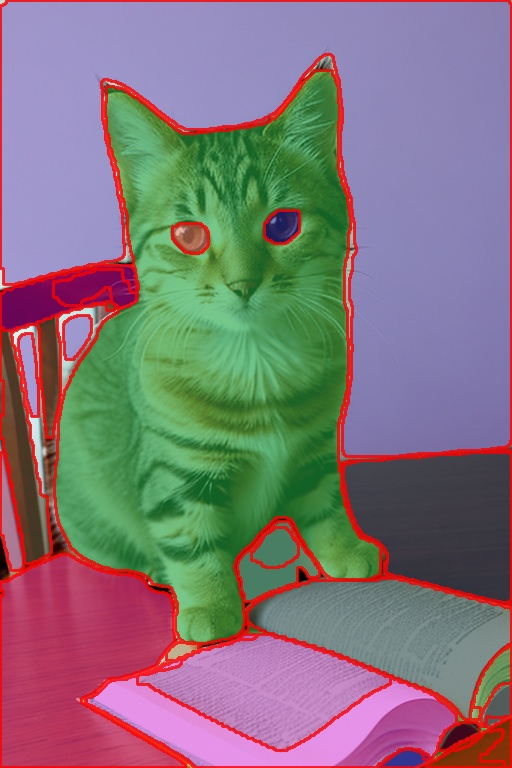

In [11]:
ann = prompt_process.everything_prompt()

print(ann.shape)

prompt_process.plot(annotations=ann,output_path='./result.jpg',)

result = cv2.imread('./result.jpg')
cv2_imshow(result)

# point

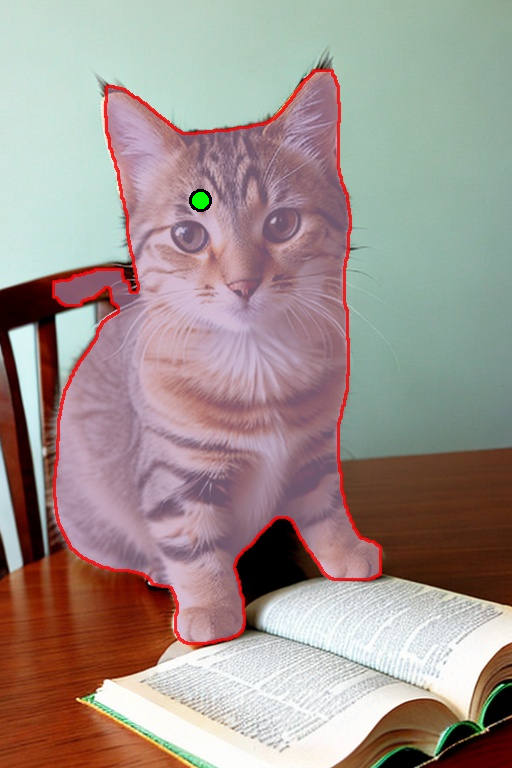

In [12]:
input_point = np.array([[200, 200]])
input_label = np.array([1])

ann = prompt_process.point_prompt(points=input_point,  pointlabel=input_label)

prompt_process.plot(annotations=ann,output_path='./result.jpg',)

result = cv2.imread('./result.jpg')
result = draw_point(result, input_point, input_label)
cv2_imshow(result)

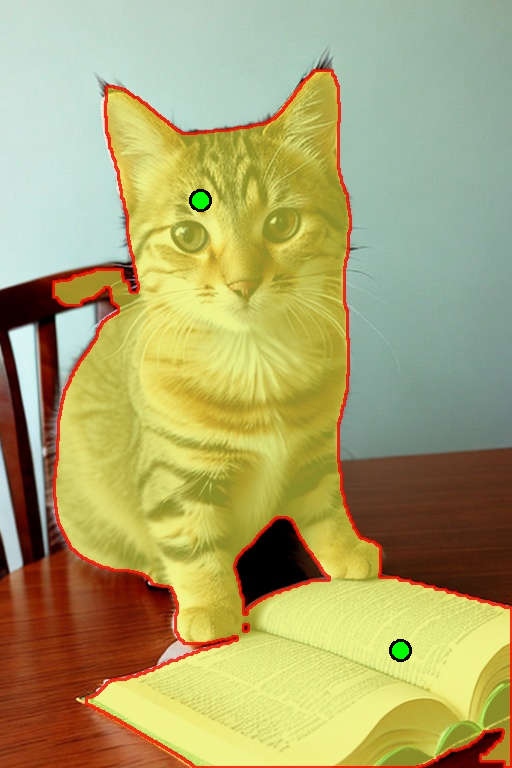

In [13]:
input_point = np.array([[200, 200], [400, 650]])
input_label = np.array([1, 1])

ann = prompt_process.point_prompt(points=input_point,  pointlabel=input_label)

prompt_process.plot(annotations=ann,output_path='./result.jpg',)

result = cv2.imread('./result.jpg')
result = draw_point(result, input_point, input_label)
cv2_imshow(result)

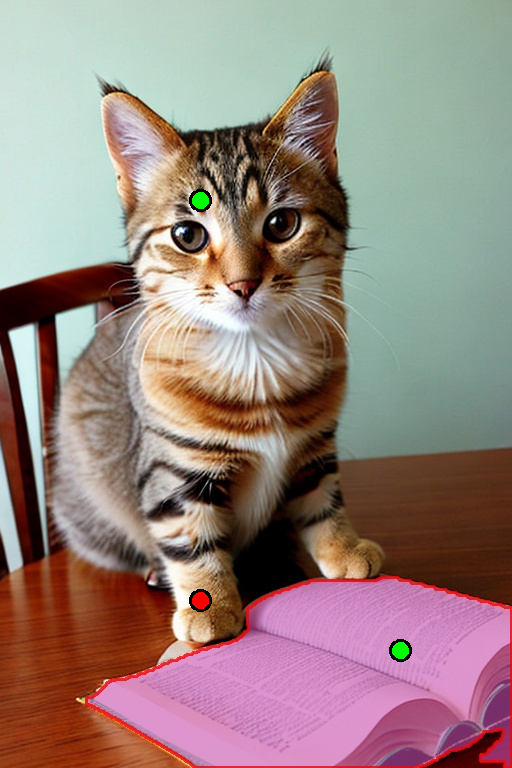

In [14]:
input_point = np.array([[200, 200], [400, 650], [200, 600]])
input_label = np.array([1, 1, 0])


ann = prompt_process.point_prompt(points=input_point,  pointlabel=input_label)

prompt_process.plot(annotations=ann,output_path='./result.jpg',)

result = cv2.imread('./result.jpg')
result = draw_point(result, input_point, input_label)
cv2_imshow(result)

## bounding box

(1, 768, 512)


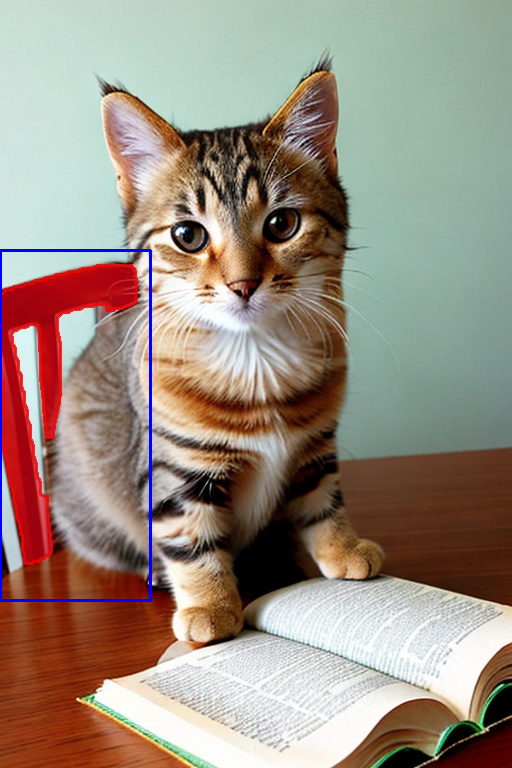

In [15]:
input_boxes = [
    [0, 250, 150, 600],
]

ann = prompt_process.box_prompt(bboxes = input_boxes)

print(ann.shape)

prompt_process.plot(annotations=ann,output_path='./result.jpg',)

result = cv2.imread('./result.jpg')
result = draw_box(result, input_boxes)
cv2_imshow(result)

(3, 768, 512)


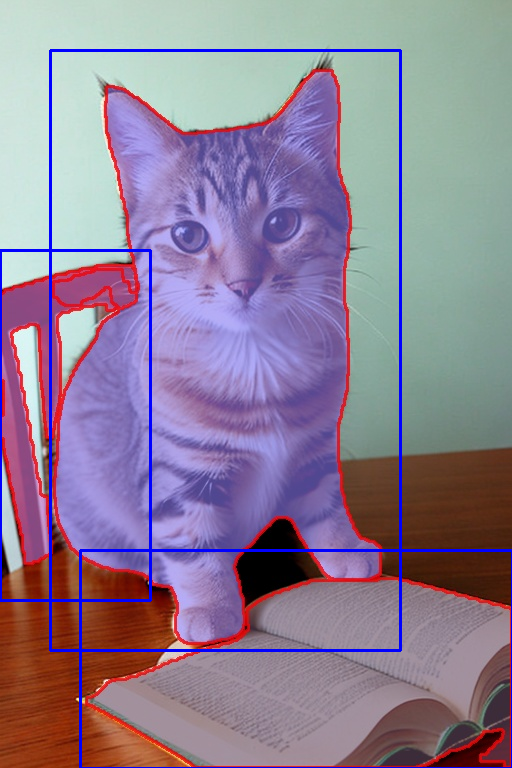

In [16]:
input_boxes = [
    [0, 250, 150, 600],
    [50, 50, 400, 650],
    [80, 550, 512, 768]
]

ann = prompt_process.box_prompt(bboxes = input_boxes)

print(ann.shape)

prompt_process.plot(annotations=ann,output_path='./result.jpg',)

result = cv2.imread('./result.jpg')
result = draw_box(result, input_boxes)
cv2_imshow(result)

# Text

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 33.3MiB/s]


(1, 768, 512)


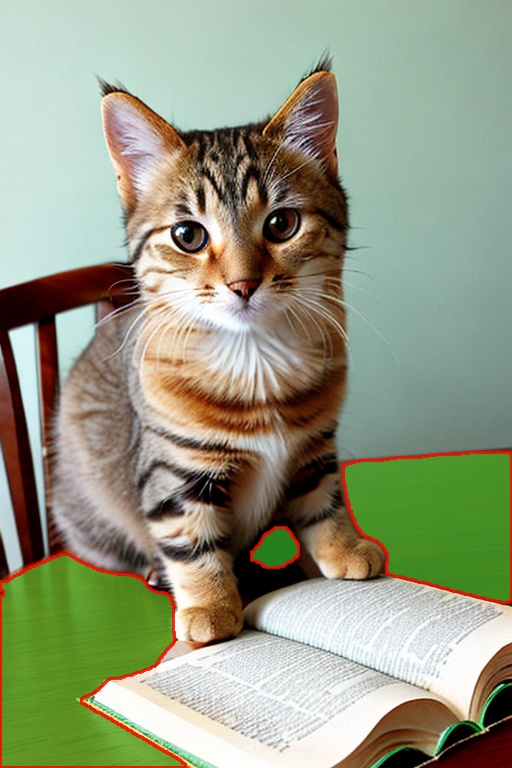

In [17]:
ann = prompt_process.text_prompt(text='cat')

print(ann.shape)

prompt_process.plot(annotations=ann,output_path='./result.jpg',)

result = cv2.imread('./result.jpg')
cv2_imshow(result)